# Résultats Corrigés - AG vs Recherche Locale avec Suivi Précis de la Convergence

Ce notebook corrige le problème de suivi de convergence de la recherche locale en utilisant la même approche que dans `best_config_SIMPLE.ipynb`.

In [1]:
# 1. IMPORTS ET CONFIGURATION
from jmetal.algorithm.singleobjective.local_search import LocalSearch
from jmetal.operator.mutation import PolynomialMutation
from jmetal.operator.crossover import SBXCrossover
from jmetal.algorithm.singleobjective.genetic_algorithm import GeneticAlgorithm
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.core.problem import Problem
from jmetal.core.solution import FloatSolution
import random
import time
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

print('✓ Imports terminés')

✓ Imports terminés


In [2]:
# 2. DÉFINITION DU PROBLÈME
class FloatPairsMax(Problem):
    def __init__(self, number_of_floats: int, min_value: float, max_value: float):
        super().__init__()
        self.number_of_floats = number_of_floats
        self.min_value = min_value
        self.max_value = max_value
        self.lower_bound = [self.min_value] * number_of_floats
        self.upper_bound = [self.max_value] * number_of_floats
        self.number_of_objectives = 1
        self.obj_directions = [self.MINIMIZE]
        self.obj_labels = ['NegativePairsCount']
    
    def number_of_variables(self) -> int:
        return self.number_of_floats
    
    def number_of_objectives(self) -> int:
        return 1
    
    def number_of_constraints(self) -> int:
        return 0
    
    def evaluate(self, solution: FloatSolution) -> FloatSolution:
        variables = solution.variables
        pairs_count = 0
        for i in range(len(variables) - 1):
            if (variables[i] * variables[i + 1] < 0) or \
               (variables[i] == 0 and variables[i + 1] < 0) or \
               (variables[i + 1] == 0 and variables[i] < 0):
                pairs_count += 1
        solution.objectives[0] = -pairs_count
        return solution
    
    def create_solution(self) -> FloatSolution:
        new_solution = FloatSolution(
            self.lower_bound,
            self.upper_bound,
            self.number_of_objectives,
            self.number_of_constraints()
        )
        new_solution.variables = [
            random.uniform(self.lower_bound[i], self.upper_bound[i])
            for i in range(self.number_of_variables())
        ]
        return new_solution
    
    def name(self) -> str:
        return 'FloatPairsMax'

print('✓ Classe problème définie')

✓ Classe problème définie


In [3]:
# 3. PARAMÈTRES EXPÉRIMENTAUX
N_FLOATS = 100
MIN_VALUE = -10.0
MAX_VALUE = 10.0
OPTIMAL_VALUE = -(N_FLOATS - 1)  # -99
MAX_EVALUATIONS = 5000
N_RUNS = 20

# Configuration LS (extraite de FP_LS(n=100).ipynb)
ls_config = {
    'nom': 'Mutation faible (0.25)',
    'mutation_probability': 0.25,
    'mutation_distribution_index': 20.0,
}

# Configuration AG (extraite de FP_AG_n=100.ipynb)
ag_config = {
    'nom': 'Population doublée',
    'population_size': 100,
    'offspring_population_size': 100,
    'mutation_probability': 1.0 / N_FLOATS,
    'mutation_distribution_index': 20.0,
    'crossover_probability': 0.9,
    'crossover_distribution_index': 20.0,
}

print('✓ Configuration prête')
print(f'  - Problème : FloatPairsMax avec {N_FLOATS} variables')
print(f'  - Budget : {MAX_EVALUATIONS} évaluations')
print(f'  - Runs : {N_RUNS} par algorithme')
print(f'  - Optimal : {OPTIMAL_VALUE} paires')

✓ Configuration prête
  - Problème : FloatPairsMax avec 100 variables
  - Budget : 5000 évaluations
  - Runs : 20 par algorithme
  - Optimal : -99 paires


In [4]:
# 4. FONCTION RECHERCHE LOCALE AVEC SUIVI DE LA FITNESS COURANTE
# Basée sur l'approche de best_config_SIMPLE.ipynb

def run_local_search_with_history(problem, config, max_evaluations):
    """
    Exécute la recherche locale avec suivi de la fitness courante à chaque évaluation.
    Retourne l'historique complet, la fitness finale et le temps d'exécution.
    """
    # Variables pour le suivi
    current_history = []  # Fitness courante à chaque évaluation
    evaluations_count = 0
    
    # Créer l'algorithme
    mutation_prob = config['mutation_probability']
    if mutation_prob is None:
        mutation_prob = 1.0 / problem.number_of_variables()
    
    mutation = PolynomialMutation(
        probability=mutation_prob,
        distribution_index=config['mutation_distribution_index']
    )
    
    algorithm = LocalSearch(
        problem=problem,
        mutation=mutation,
        termination_criterion=StoppingByEvaluations(max_evaluations=max_evaluations)
    )
    
    # Surcharger la méthode step pour suivre la fitness courante
    original_step = algorithm.step
    
    def tracked_step():
        nonlocal evaluations_count, current_history
        
        # Exécuter un step normal
        original_step()
        
        # Suivre la fitness courante
        if algorithm.solutions:
            current_fitness = algorithm.solutions[0].objectives[0]
            current_history.append(current_fitness)
            evaluations_count += 1
    
    # Remplacer la méthode step
    algorithm.step = tracked_step
    
    # Exécution
    start_time = time.time()
    algorithm.run()
    exec_time = time.time() - start_time
    
    # Récupérer la valeur finale
    if algorithm.solutions:
        final_fitness = algorithm.solutions[0].objectives[0]
    else:
        final_fitness = current_history[-1] if current_history else OPTIMAL_VALUE
    
    # Limiter à max_evaluations points
    if len(current_history) > max_evaluations:
        current_history = current_history[:max_evaluations]
    
    return {
        'history': current_history,
        'final': final_fitness,
        'time': exec_time,
        'evaluations': len(current_history)
    }

print('✓ Fonction de recherche locale avec historique définie')

✓ Fonction de recherche locale avec historique définie


In [5]:
# 5. FONCTION ALGORITHME GÉNÉTIQUE AVEC SUIVI DE LA FITNESS COURANTE
# Basée sur l'approche de best_config_SIMPLE.ipynb

def run_genetic_algorithm_with_history(problem, config, max_evaluations):
    """
    Exécute l'AG avec suivi de la fitness courante à chaque évaluation.
    Retourne l'historique complet, la fitness finale et le temps d'exécution.
    """
    # Variables pour le suivi
    current_history = []
    evaluations_count = 0
    
    # Créer l'algorithme
    mutation = PolynomialMutation(
        probability=config['mutation_probability'],
        distribution_index=config['mutation_distribution_index']
    )
    crossover = SBXCrossover(
        probability=config['crossover_probability'],
        distribution_index=config['crossover_distribution_index']
    )
    
    algorithm = GeneticAlgorithm(
        problem=problem,
        population_size=config['population_size'],
        offspring_population_size=config['offspring_population_size'],
        mutation=mutation,
        crossover=crossover,
        termination_criterion=StoppingByEvaluations(max_evaluations)
    )
    
    # Surcharger la méthode evaluate pour suivre manuellement
    original_evaluate = algorithm.evaluate
    
    def tracked_evaluate(population):
        nonlocal evaluations_count, current_history
        
        # Évaluation normale
        result = original_evaluate(population)
        
        # Suivre la fitness de la meilleure solution courante
        current_best = None
        if algorithm.solutions:
            for solution in algorithm.solutions:
                if current_best is None or solution.objectives[0] > current_best:
                    current_best = solution.objectives[0]
        
        # Enregistrer la fitness courante pour chaque individu évalué
        if current_best is not None:
            for _ in range(len(population)):
                current_history.append(current_best)
                evaluations_count += 1
        
        return result
    
    # Remplacer la méthode d'évaluation
    algorithm.evaluate = tracked_evaluate
    
    # Exécution
    start_time = time.time()
    algorithm.run()
    exec_time = time.time() - start_time
    
    # Récupérer la valeur finale
    if algorithm.solutions:
        final_fitness = algorithm.solutions[0].objectives[0]
    else:
        final_fitness = current_history[-1] if current_history else OPTIMAL_VALUE
    
    # Limiter à max_evaluations points
    if len(current_history) > max_evaluations:
        current_history = current_history[:max_evaluations]
    
    return {
        'history': current_history,
        'final': final_fitness,
        'time': exec_time,
        'evaluations': len(current_history)
    }

print('✓ Fonction AG avec historique définie')

✓ Fonction AG avec historique définie


In [6]:
# 6. EXÉCUTION RECHERCHE LOCALE
print('='*60)
print('EXÉCUTION RECHERCHE LOCALE - AVEC SUIVI COMPLET')
print('='*60)

ls_histories = []
ls_finals = []
ls_times = []
ls_evaluations = []

for i in tqdm(range(N_RUNS), desc="LS"):
    problem_ls = FloatPairsMax(N_FLOATS, MIN_VALUE, MAX_VALUE)
    result = run_local_search_with_history(problem_ls, ls_config, MAX_EVALUATIONS)
    
    ls_histories.append(result['history'])
    ls_finals.append(result['final'])
    ls_times.append(result['time'])
    ls_evaluations.append(result['evaluations'])
    
    if i == 0:
        print(f"\n  Premier run LS:")
        print(f"    Nombre de points: {len(result['history'])}")
        print(f"    Premières valeurs: {result['history'][:5]}")
        print(f"    Dernières valeurs: {result['history'][-5:]}")
        print(f"    Final: {result['final']:.2f} ({-result['final']:.0f} paires)")

print(f"\n✓ Recherche Locale terminée")
print(f"  Fitness moyenne : {np.mean(ls_finals):.2f} ({-np.mean(ls_finals):.2f} paires)")
print(f"  Écart-type : {np.std(ls_finals):.2f}")
print(f"  Temps moyen : {np.mean(ls_times):.3f}s")
print(f"  Évaluations moyennes : {np.mean(ls_evaluations):.0f}")

EXÉCUTION RECHERCHE LOCALE - AVEC SUIVI COMPLET


LS:   0%|          | 0/20 [00:00<?, ?it/s][2026-02-02 12:14:28,752] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 12:14:28,948] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 12:14:28,950] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 12:14:29,003] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-02-02 12:14:34,605] [jmetal.core.algorithm] [DEBUG] Finished!
LS:   5%|▌         | 1/20 [00:05<01:51,  5.86s/it][2026-02-02 12:14:34,610] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 12:14:34,612] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 12:14:34,613] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 12:14:34,614] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met



  Premier run LS:
    Nombre de points: 5000
    Premières valeurs: [-44, -44, -46, -46, -46]
    Dernières valeurs: [-88, -88, -88, -88, -88]
    Final: -88.00 (88 paires)


[2026-02-02 12:14:37,303] [jmetal.core.algorithm] [DEBUG] Finished!
LS:  10%|█         | 2/20 [00:08<01:11,  4.00s/it][2026-02-02 12:14:37,311] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 12:14:37,313] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 12:14:37,315] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 12:14:37,319] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-02-02 12:14:40,709] [jmetal.core.algorithm] [DEBUG] Finished!
LS:  15%|█▌        | 3/20 [00:11<01:03,  3.73s/it][2026-02-02 12:14:40,712] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 12:14:40,713] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 12:14:40,714] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 12:14:40,715] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-02-02 12:14:43,192


✓ Recherche Locale terminée
  Fitness moyenne : -89.70 (89.70 paires)
  Écart-type : 1.90
  Temps moyen : 1.587s
  Évaluations moyennes : 5000


In [7]:
# 7. EXÉCUTION ALGORITHME GÉNÉTIQUE
print('\n' + '='*60)
print('EXÉCUTION ALGORITHME GÉNÉTIQUE - AVEC SUIVI COMPLET')
print('='*60)

ag_histories = []
ag_finals = []
ag_times = []
ag_evaluations = []

for i in tqdm(range(N_RUNS), desc="AG"):
    problem_ag = FloatPairsMax(N_FLOATS, MIN_VALUE, MAX_VALUE)
    result = run_genetic_algorithm_with_history(problem_ag, ag_config, MAX_EVALUATIONS)
    
    ag_histories.append(result['history'])
    ag_finals.append(result['final'])
    ag_times.append(result['time'])
    ag_evaluations.append(result['evaluations'])
    
    if i == 0:
        print(f"\n  Premier run AG:")
        print(f"    Nombre de points: {len(result['history'])}")
        print(f"    Premières valeurs: {result['history'][:5]}")
        print(f"    Dernières valeurs: {result['history'][-5:]}")
        print(f"    Final: {result['final']:.2f} ({-result['final']:.0f} paires)")

print(f"\n✓ Algorithme Génétique terminé")
print(f"  Fitness moyenne : {np.mean(ag_finals):.2f} ({-np.mean(ag_finals):.2f} paires)")
print(f"  Écart-type : {np.std(ag_finals):.2f}")
print(f"  Temps moyen : {np.mean(ag_times):.3f}s")
print(f"  Évaluations moyennes : {np.mean(ag_evaluations):.0f}")


EXÉCUTION ALGORITHME GÉNÉTIQUE - AVEC SUIVI COMPLET


AG:   0%|          | 0/20 [00:00<?, ?it/s][2026-02-02 12:15:00,541] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 12:15:00,548] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 12:15:00,550] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 12:15:00,551] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-02-02 12:15:01,624] [jmetal.core.algorithm] [DEBUG] Finished!
AG:   5%|▌         | 1/20 [00:01<00:20,  1.08s/it][2026-02-02 12:15:01,625] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 12:15:01,628] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 12:15:01,630] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 12:15:01,631] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met



  Premier run AG:
    Nombre de points: 5000
    Premières valeurs: [-34, -34, -34, -34, -34]
    Dernières valeurs: [-90, -90, -90, -90, -90]
    Final: -90.00 (90 paires)


[2026-02-02 12:15:02,718] [jmetal.core.algorithm] [DEBUG] Finished!
AG:  10%|█         | 2/20 [00:02<00:19,  1.09s/it][2026-02-02 12:15:02,719] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 12:15:02,722] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 12:15:02,725] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 12:15:02,725] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-02-02 12:15:03,679] [jmetal.core.algorithm] [DEBUG] Finished!
AG:  15%|█▌        | 3/20 [00:03<00:17,  1.03s/it][2026-02-02 12:15:03,681] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 12:15:03,683] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 12:15:03,684] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 12:15:03,685] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-02-02 12:15:04,592


✓ Algorithme Génétique terminé
  Fitness moyenne : -86.35 (86.35 paires)
  Écart-type : 3.05
  Temps moyen : 0.979s
  Évaluations moyennes : 5000


In [8]:
# 8. ALIGNEMENT DES HISTORIQUES
print('\n' + '='*60)
print('ALIGNEMENT DES HISTORIQUES')
print('='*60)

def align_to_evaluations(histories, target_evaluations):
    """Aligne les historiques à un nombre cible d'évaluations."""
    aligned = []
    for h in histories:
        if len(h) == target_evaluations:
            aligned.append(h)
        elif len(h) < target_evaluations:
            # Compléter avec la dernière valeur
            h = h + [h[-1]] * (target_evaluations - len(h))
            aligned.append(h)
        else:  # len(h) > target_evaluations
            # Tronquer
            aligned.append(h[:target_evaluations])
    return np.array(aligned)

# Aligner à MAX_EVALUATIONS
ls_aligned = align_to_evaluations(ls_histories, MAX_EVALUATIONS)
ag_aligned = align_to_evaluations(ag_histories, MAX_EVALUATIONS)

print(f"  LS shape: {ls_aligned.shape}")
print(f"  AG shape: {ag_aligned.shape}")

# Calculer moyennes et écarts-types
ls_mean = np.mean(ls_aligned, axis=0)
ls_std = np.std(ls_aligned, axis=0)

ag_mean = np.mean(ag_aligned, axis=0)
ag_std = np.std(ag_aligned, axis=0)

# Axe X (nombre d'évaluations)
x_axis = np.arange(1, MAX_EVALUATIONS + 1)

print(f"\n✓ Moyennes calculées")
print(f"  LS final : {ls_mean[-1]:.2f} ± {ls_std[-1]:.2f}")
print(f"  AG final : {ag_mean[-1]:.2f} ± {ag_std[-1]:.2f}")
print(f"  Différence : {ag_mean[-1] - ls_mean[-1]:.2f} points")


ALIGNEMENT DES HISTORIQUES
  LS shape: (20, 5000)
  AG shape: (20, 5000)

✓ Moyennes calculées
  LS final : -89.70 ± 1.90
  AG final : -86.35 ± 3.05
  Différence : 3.35 points



GÉNÉRATION DU GRAPHIQUE DE CONVERGENCE


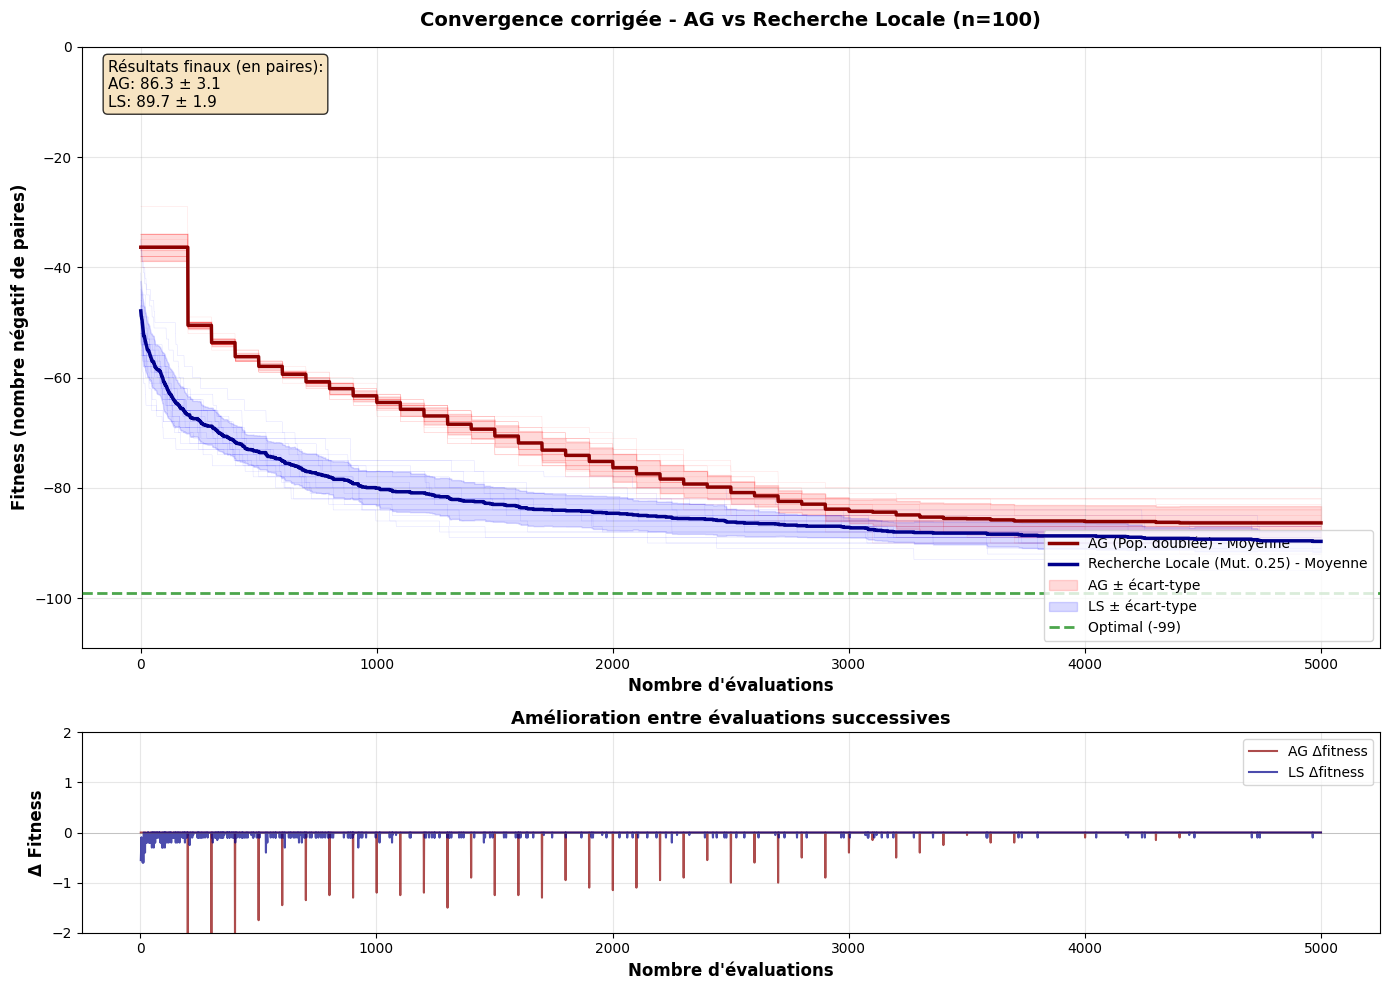


✓ Graphique de convergence généré


In [9]:
# 9. GRAPHIQUE PRINCIPAL - CONVERGENCE CORRIGÉE
print('\n' + '='*60)
print('GÉNÉRATION DU GRAPHIQUE DE CONVERGENCE')
print('='*60)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), height_ratios=[3, 1])

# ====== GRAPHIQUE PRINCIPAL : CONVERGENCE ======
# AG - Runs individuels (rouge transparent)
for h in ag_histories:
    if len(h) > 0:
        ax1.plot(range(1, len(h)+1), h, color='red', alpha=0.15, linewidth=0.3)

# LS - Runs individuels (bleu transparent)
for h in ls_histories:
    if len(h) > 0:
        ax1.plot(range(1, len(h)+1), h, color='blue', alpha=0.15, linewidth=0.3)

# Moyennes en gras
ax1.plot(x_axis, ag_mean, color='darkred', linewidth=2.5, 
         label='AG (Pop. doublée) - Moyenne', zorder=10)
ax1.plot(x_axis, ls_mean, color='darkblue', linewidth=2.5, 
         label='Recherche Locale (Mut. 0.25) - Moyenne', zorder=10)

# Zones d'écart-type
ax1.fill_between(x_axis, ag_mean - ag_std, ag_mean + ag_std, 
                 color='red', alpha=0.15, label='AG ± écart-type')
ax1.fill_between(x_axis, ls_mean - ls_std, ls_mean + ls_std, 
                 color='blue', alpha=0.15, label='LS ± écart-type')

# Ligne optimale
ax1.axhline(y=OPTIMAL_VALUE, color='green', linestyle='--', linewidth=2, 
           alpha=0.7, label=f'Optimal ({OPTIMAL_VALUE})', zorder=5)

ax1.set_xlabel("Nombre d'évaluations", fontsize=12, fontweight='bold')
ax1.set_ylabel('Fitness (nombre négatif de paires)', fontsize=12, fontweight='bold')
ax1.set_title('Convergence corrigée - AG vs Recherche Locale (n=100)', 
             fontsize=14, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='lower right', fontsize=10)
ax1.set_ylim([OPTIMAL_VALUE - 10, 0])

# Encadré avec résultats finaux
textstr = f'Résultats finaux (en paires):\nAG: {-ag_mean[-1]:.1f} ± {ag_std[-1]:.1f}\nLS: {-ls_mean[-1]:.1f} ± {ls_std[-1]:.1f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax1.text(0.02, 0.98, textstr, transform=ax1.transAxes, fontsize=11,
        verticalalignment='top', bbox=props)

# ====== GRAPHIQUE DES AMÉLIORATIONS ======
# Calculer le delta entre évaluations successives
ag_delta = np.diff(ag_mean)
ls_delta = np.diff(ls_mean)

ax2.plot(x_axis[1:], ag_delta, color='darkred', linewidth=1.5, 
         alpha=0.7, label='AG Δfitness')
ax2.plot(x_axis[1:], ls_delta, color='darkblue', linewidth=1.5, 
         alpha=0.7, label='LS Δfitness')

# Ligne à y=0
ax2.axhline(y=0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)

ax2.set_xlabel("Nombre d'évaluations", fontsize=12, fontweight='bold')
ax2.set_ylabel('Δ Fitness', fontsize=12, fontweight='bold')
ax2.set_title('Amélioration entre évaluations successives', 
             fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper right', fontsize=10)
ax2.set_ylim([-2, 2])

plt.tight_layout()
plt.show()

print('\n✓ Graphique de convergence généré')


GÉNÉRATION DES GRAPHIQUES COMPLÉMENTAIRES


/var/folders/rh/xt3snpjn7ng64htp00_8m9nw0000gn/T/ipykernel_53330/34982813.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([ls_pairs, ag_pairs], labels=['LS', 'AG'],


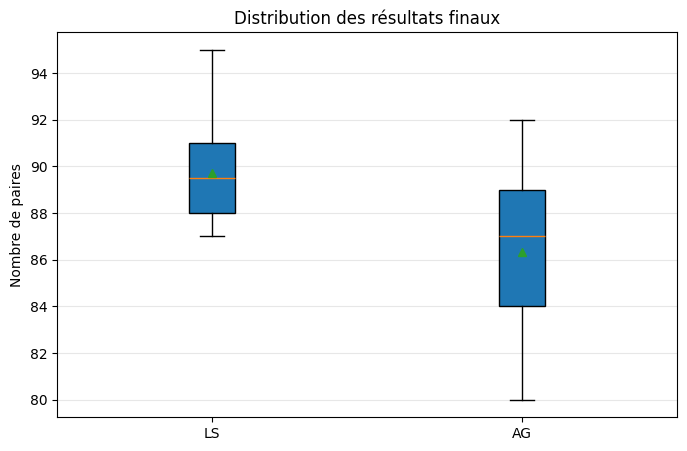

/var/folders/rh/xt3snpjn7ng64htp00_8m9nw0000gn/T/ipykernel_53330/34982813.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([ls_times, ag_times], labels=['LS', 'AG'],


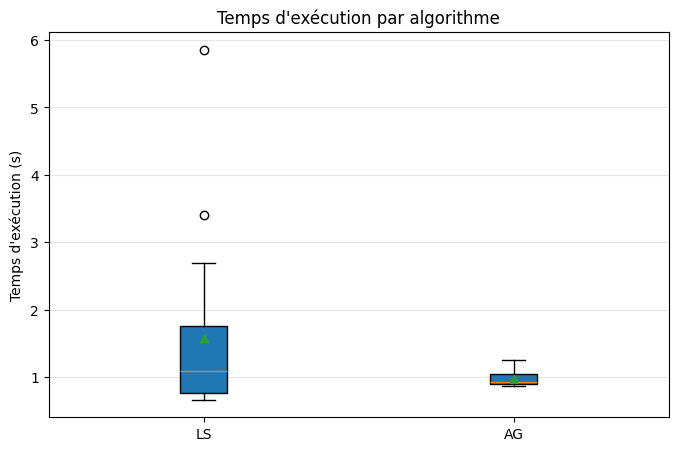

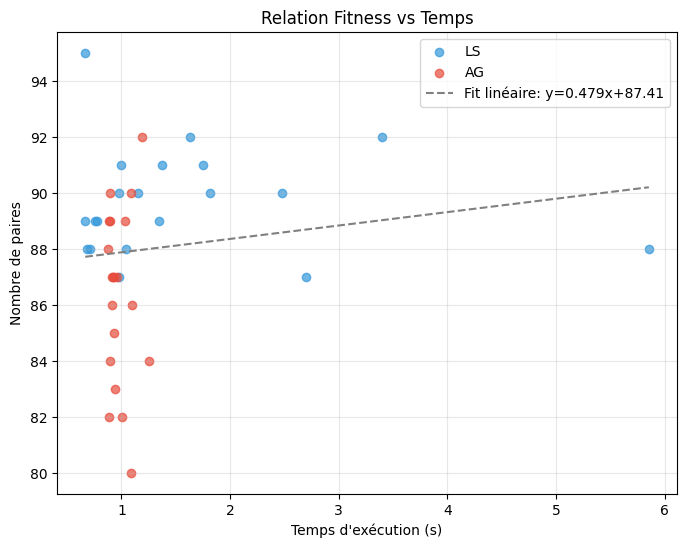

✓ Graphiques complémentaires générés


In [10]:
# 10. AUTRES GRAPHIQUES COMPARATIFS
print('\n' + '='*60)
print('GÉNÉRATION DES GRAPHIQUES COMPLÉMENTAIRES')
print('='*60)

# Convertir en nombre de paires (valeurs positives)
ls_pairs = [-f for f in ls_finals]
ag_pairs = [-f for f in ag_finals]

# 1. Boxplot des fitness finaux
plt.figure(figsize=(8, 5))
plt.boxplot([ls_pairs, ag_pairs], labels=['LS', 'AG'], 
            patch_artist=True, showmeans=True)
plt.ylabel('Nombre de paires')
plt.title('Distribution des résultats finaux')
plt.grid(True, axis='y', alpha=0.3)
plt.show()

# 2. Boxplot des temps d'exécution
plt.figure(figsize=(8, 5))
plt.boxplot([ls_times, ag_times], labels=['LS', 'AG'], 
            patch_artist=True, showmeans=True)
plt.ylabel("Temps d'exécution (s)")
plt.title("Temps d'exécution par algorithme")
plt.grid(True, axis='y', alpha=0.3)
plt.show()

# 3. Relation fitness vs temps
plt.figure(figsize=(8, 6))
plt.scatter(ls_times, ls_pairs, alpha=0.7, label='LS', color='#3498db')
plt.scatter(ag_times, ag_pairs, alpha=0.7, label='AG', color='#e74c3c')

# Fit linéaire
all_times = np.array(ls_times + ag_times)
all_pairs = np.array(ls_pairs + ag_pairs)
if len(all_times) > 1:
    coef = np.polyfit(all_times, all_pairs, 1)
    x_line = np.linspace(all_times.min(), all_times.max(), 100)
    y_line = np.polyval(coef, x_line)
    plt.plot(x_line, y_line, color='gray', linestyle='--', 
             label=f'Fit linéaire: y={coef[0]:.3f}x+{coef[1]:.2f}')

plt.xlabel("Temps d'exécution (s)")
plt.ylabel('Nombre de paires')
plt.title('Relation Fitness vs Temps')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print('✓ Graphiques complémentaires générés')

In [11]:
# 11. TABLEAU DE SYNTHÈSE
print('\n' + '='*60)
print('TABLEAU DE SYNTHÈSE COMPARATIF')
print('='*60)

# Calculs statistiques
ls_success = sum(1 for f in ls_finals if f == OPTIMAL_VALUE) / N_RUNS * 100
ag_success = sum(1 for f in ag_finals if f == OPTIMAL_VALUE) / N_RUNS * 100

# Créer le tableau
summary = pd.DataFrame([
    {
        'Algorithme': 'Recherche Locale',
        'Config': ls_config['nom'],
        'Fitness moyenne': f"{np.mean(ls_finals):.2f}",
        'Paires moyennes': f"{-np.mean(ls_finals):.2f}",
        'Médiane': f"{np.median(ls_finals):.2f}",
        'Écart-type': f"{np.std(ls_finals):.2f}",
        'Min (meilleur)': f"{np.max(ls_finals):.0f}",
        'Max (pire)': f"{np.min(ls_finals):.0f}",
        'Taux succès (%)': f"{ls_success:.1f}",
        'Temps moyen (s)': f"{np.mean(ls_times):.3f}"
    },
    {
        'Algorithme': 'Algorithme Génétique',
        'Config': ag_config['nom'],
        'Fitness moyenne': f"{np.mean(ag_finals):.2f}",
        'Paires moyennes': f"{-np.mean(ag_finals):.2f}",
        'Médiane': f"{np.median(ag_finals):.2f}",
        'Écart-type': f"{np.std(ag_finals):.2f}",
        'Min (meilleur)': f"{np.max(ag_finals):.0f}",
        'Max (pire)': f"{np.min(ag_finals):.0f}",
        'Taux succès (%)': f"{ag_success:.1f}",
        'Temps moyen (s)': f"{np.mean(ag_times):.3f}"
    }
])

display(summary)

print('\n✓ Tableau de synthèse généré')


TABLEAU DE SYNTHÈSE COMPARATIF


,Algorithme,Config,Fitness moyenne,Paires moyennes,Médiane,Écart-type,Min (meilleur),Max (pire),Taux succès (%),Temps moyen (s)
0,Recherche Locale,Mutation faible (0.25),-89.70,89.70,-89.50,1.90,-87,-95,0.0,1.587
1,Algorithme Génétique,Population doublée,-86.35,86.35,-87.00,3.05,-80,-92,0.0,0.979



✓ Tableau de synthèse généré


In [12]:
# 12. TEST STATISTIQUE
print('\n' + '='*60)
print('TEST STATISTIQUE')
print('='*60)

try:
    from scipy.stats import mannwhitneyu, ttest_ind
    
    # Test de Mann-Whitney U (non-paramétrique)
    u_stat, p_value_mw = mannwhitneyu(ls_pairs, ag_pairs, alternative='two-sided')
    print(f"Mann-Whitney U test:")
    print(f"  U-statistique: {u_stat:.2f}")
    print(f"  p-value: {p_value_mw:.6f}")
    
    if p_value_mw < 0.05:
        print(f"  → Différence statistiquement significative (p < 0.05)")
    else:
        print(f"  → Pas de différence significative (p >= 0.05)")
    
    # Test t de Student (paramétrique)
    t_stat, p_value_t = ttest_ind(ls_pairs, ag_pairs)
    print(f"\nTest t de Student:")
    print(f"  t-statistique: {t_stat:.2f}")
    print(f"  p-value: {p_value_t:.6f}")
    
    # Taille d'effet (Cohen's d)
    pooled_std = np.sqrt((np.std(ls_pairs)**2 + np.std(ag_pairs)**2) / 2)
    cohens_d = (np.mean(ls_pairs) - np.mean(ag_pairs)) / pooled_std
    print(f"\nTaille d'effet (Cohen's d): {cohens_d:.3f}")
    
    if abs(cohens_d) < 0.2:
        effect_size = "faible"
    elif abs(cohens_d) < 0.5:
        effect_size = "moyen"
    else:
        effect_size = "fort"
    print(f"  → Effet {effect_size}")
    
except ImportError:
    print("SciPy non disponible - tests statistiques non effectués")
except Exception as e:
    print(f"Erreur lors des tests statistiques: {e}")

print('\n' + '='*60)
print('ANALYSE TERMINÉE')
print('='*60)


TEST STATISTIQUE
Mann-Whitney U test:
  U-statistique: 326.00
  p-value: 0.000626
  → Différence statistiquement significative (p < 0.05)

Test t de Student:
  t-statistique: 4.06
  p-value: 0.000236

Taille d'effet (Cohen's d): 1.317
  → Effet fort

ANALYSE TERMINÉE
